<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FlightOnTime ✈️ Predicción de Retrasos Aéreos
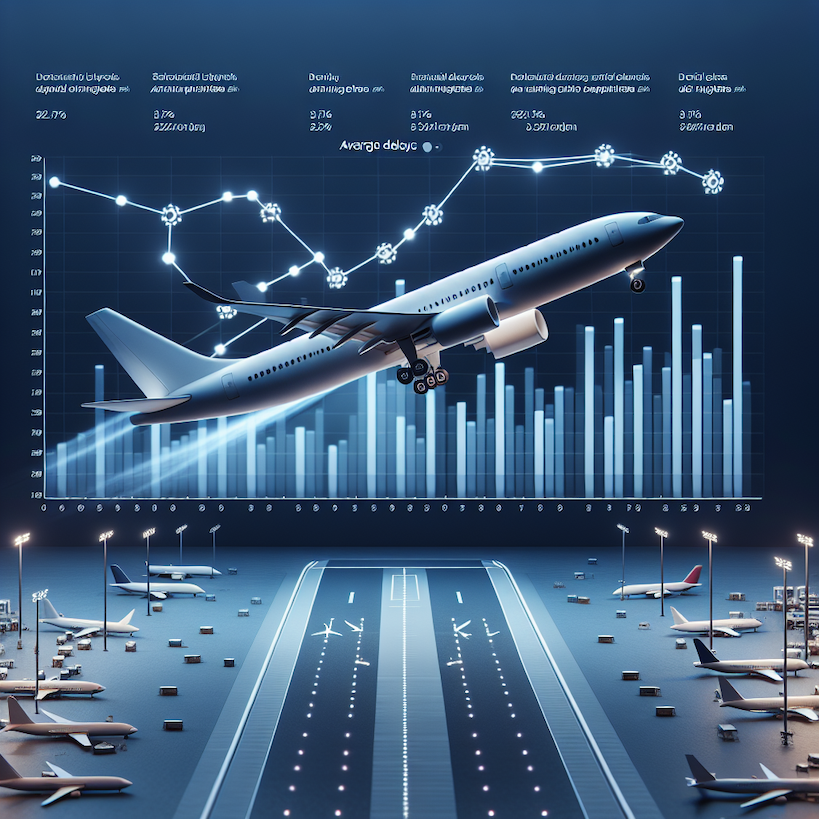

## Contexto
Los retrasos aéreos generan costos operativos, insatisfacción de pasajeros
y problemas logísticos. Este proyecto busca predecir si un vuelo
despegará puntual o con retraso, usando información disponible antes del vuelo.

## Objetivo
Desarrollar un modelo de Machine Learning capaz de predecir si un vuelo será Puntual o Retrasado, utilizando información disponible antes del despegue, como datos operativos y condiciones climáticas.

El resultado es un modelo listo para ser consumido por una API REST, permitiendo su uso en tiempo real por aerolíneas, aeropuertos o sistemas externos.

## Contexto del Problema

Los retrasos en vuelos generan:

insatisfacción en los pasajeros,

aumento de costos operativos,

problemas logísticos (conexiones perdidas, reprogramaciones).

Este proyecto busca anticipar el riesgo de retraso, permitiendo tomar decisiones preventivas y mejorar la planificación operativa.


## Definición del Problema de Data Science

Tipo de problema: Clasificación binaria

Variable objetivo: delayed

0 → Vuelo puntual

1 → Vuelo retrasado

Pregunta que responde el modelo:

¿Este vuelo tiene una alta probabilidad de retrasarse?

---------

# **1. 📚 Librerías y configuración**

In [144]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc
)

import joblib
import kagglehub
import pyarrow.parquet as pq

sns.set(style="whitegrid")

## Descargar el dataset de Rafael para el analisis e entrenamiento

In [87]:
!pip install kagglehub pyarrow requests

In [88]:

path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
print(path)

parquet_file = "/kaggle/input/flight-delay/Flight_Delay.parquet"
n_sample = 100_000   #Limito filas

pf = pq.ParquetFile(parquet_file)  #Abre parte del parquet si cargarse la memoria


Using Colab cache for faster access to the 'flight-delay' dataset.
/kaggle/input/flight-delay


## Cargar dataset por bloques

In [89]:
#loop muestreo. Lee parquet por bloques, junta filas, no carga todo el dataset.
rows = []
rows_read = 0

for batch in pf.iter_batches(batch_size=50_000): #, columns=columns_needed):
    df_batch = batch.to_pandas()
    remaining = n_sample - rows_read
    if remaining <= 0:
        break
    if len(df_batch) > remaining:
        df_batch = df_batch.sample(remaining, random_state=42)
    rows.append(df_batch)
    rows_read += len(df_batch)

#dataframe resultado uniendo batches

df = pd.concat(rows, ignore_index=True)


## **Inspección visual**




### Visualizar las primeras 5 filas.

In [90]:
df.head()

,Year,Month,DayofMonth,FlightDate,Marketing_Airline_Network,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelay,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,15,2018-01-15,UA,"Newark, NJ","Charleston, SC",1845,1928.0,43.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,2018-01-16,UA,"Newark, NJ","Charleston, SC",1835,1956.0,81.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,2018-01-17,UA,"Newark, NJ","Charleston, SC",1835,1836.0,1.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,2018-01-18,UA,"Newark, NJ","Charleston, SC",1845,1844.0,-1.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,2018-01-20,UA,"Newark, NJ","Charleston, SC",1835,1829.0,-6.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


### **Estructura**

*   Revisar cuántas filas y columnas hay.

In [91]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (100000, 29)


*   Qué tipo de datos contiene cada una (¿son números, fechas, texto?)

In [92]:
df.dtypes

,0
Year,int64
Month,int64
DayofMonth,int64
FlightDate,object
Marketing_Airline_Network,object
OriginCityName,object
DestCityName,object
CRSDepTime,int64
DepTime,float64
DepDelay,float64


### **Estadística básica**

*   Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [93]:
df.describe()

,Year,Month,DayofMonth,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,100000.0,100000.0,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.0,1.0,14.879780,1327.535980,1335.14702,10.116290,13.661770,15.976660,1358.813680,1467.842620,...,137.979840,130.186510,107.180340,764.650600,3.527760,4.647050,0.703230,2.550650,0.018280,5.256900
std,0.0,0.0,9.050645,487.958328,498.49002,49.230517,48.086319,9.642199,498.267314,521.188453,...,74.304854,72.336005,69.939664,586.343365,2.280382,32.336684,13.665402,15.254682,1.211726,25.825928
min,2018.0,1.0,1.000000,1.000000,1.00000,-45.000000,0.000000,1.000000,1.000000,1.000000,...,18.000000,11.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,1.0,7.000000,915.000000,920.00000,-6.000000,0.000000,10.000000,934.000000,1049.000000,...,85.000000,79.000000,58.000000,345.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2018.0,1.0,15.000000,1319.000000,1329.00000,-3.000000,0.000000,14.000000,1342.000000,1506.000000,...,120.000000,113.000000,89.000000,604.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2018.0,1.0,23.000000,1730.000000,1741.00000,4.000000,4.000000,18.000000,1755.000000,1910.000000,...,171.000000,162.000000,137.000000,1005.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2018.0,1.0,31.000000,2359.000000,2400.00000,1682.000000,1682.000000,157.000000,2400.000000,2400.000000,...,704.000000,712.000000,683.000000,4983.000000,11.000000,1469.000000,1682.000000,1317.000000,264.000000,1342.000000



---

> **Aquí las estadísticas clave que estás viendo**:
>
> - **count (conteo)**: Es el número de observaciones no nulas en cada columna. En este conjunto de datos, todas las columnas numéricas tienen 100,000 entradas, lo que significa que no hay valores faltantes en estas columnas.
>
> - **mean (media)**: Es el valor promedio de cada columna. Por ejemplo, el promedio de `DepDelay` (retraso de salida) es de aproximadamente 10.12 minutos, y la distancia promedio de los vuelos es de alrededor de 764.65 millas.
>
> - **std (desviación estándar)**: Mide la cantidad de variación o dispersión de un conjunto de valores. Una desviación estándar alta indica que los datos están más dispersos, mientras que una baja indica que los datos tienden a estar cerca de la media. Por ejemplo, `DepDelay` tiene una desviación estándar de 49.23, lo que es bastante alto en comparación con su media, sugiriendo que hay una variabilidad significativa en los retrasos de salida.
>
> - **min (mínimo)**: Es el valor mínimo en cada columna. Para `DepDelay`, el mínimo es -45, lo que indica que algunos vuelos salieron 45 minutos antes de lo programado.
>
> - **25% (Q1)**: Es el primer cuartil, lo que significa que el 25% de los datos están por debajo de este valor.
>
> - **50% (Q2)**: Es el segundo cuartil o mediana, que es el valor medio cuando los datos están ordenados. Para `DepDelay`, la mediana es de -3 minutos, lo que implica que al menos la mitad de los vuelos salieron a tiempo o antes.
>
> - **75% (Q3)**: Es el tercer cuartil, lo que significa que el 75% de los datos están por debajo de este valor.
>
> - **max (máximo)**: Es el valor máximo en cada columna. Para `DepDelay`, el máximo es de 1682 minutos, lo que indica que algunos vuelos experimentaron retrasos muy largos.



# **2. Limpieza de Datos (Data Cleaning)**

### **Valores faltantes**

*   ¿Hay celdas vacías? Debes decidir si borras esas filas o rellenas los huecos con la media o un valor lógico.

In [94]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Year                       100000 non-null  int64  
 1   Month                      100000 non-null  int64  
 2   DayofMonth                 100000 non-null  int64  
 3   FlightDate                 100000 non-null  object 
 4   Marketing_Airline_Network  100000 non-null  object 
 5   OriginCityName             100000 non-null  object 
 6   DestCityName               100000 non-null  object 
 7   CRSDepTime                 100000 non-null  int64  
 8   DepTime                    100000 non-null  float64
 9   DepDelay                   100000 non-null  float64
 10  DepDelayMinutes            100000 non-null  float64
 11  TaxiOut                    100000 non-null  float64
 12  WheelsOff                  100000 non-null  float64
 13  WheelsOn                   100

---
> Según la salida de `df.info()`, todas las columnas en ese conjunto de datos muestran un conteo de no nulos de 100,000, lo que coincide con el índice de rango total de 100,000 entradas. Esto significa que no hay valores faltantes en este DataFrame. Por lo tanto, no es necesario tomar ninguna medida para eliminar filas o llenar espacios vacíos.

### **Duplicados**

*   Eliminar registros repetidos que puedan sesgar los resultados.

In [95]:
num_duplicates = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicates}")

Número de filas duplicadas: 0


---
> La salida muestra: `"Number of duplicate rows: 0"`. Esto significa que no hay entradas duplicadas en el DataFrame, por lo que no es necesario tomar medidas adicionales para eliminarlas.



### **Formateo**

*  Asegurarse de que las fechas sean tratadas como fechas y no como simple texto.
*  Convertir fecha/hora a datetime.

In [96]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])
print(df['FlightDate'].dtypes)

datetime64[ns]


---


> La columna `FlightDate` se ha convertido exitosamente al tipo de dato `datetime64[ns]`, lo que significa que está correctamente formateada para cualquier operación o análisis basado en fechas.



# **3. Análisis Exploratorio de Datos (EDA)**

## **Detección de Outliers**

Identificar valores atípicos (por ejemplo, un sueldo de un billón de dólares en una lista de empleados comunes) que podrían arruinar el modelo.

In [97]:
df_numeric = df.select_dtypes(include='number')
print(f"Forma del DataFrame numérico: {df_numeric.shape}")
df_numeric.head()

Forma del DataFrame numérico: (100000, 25)


,Year,Month,DayofMonth,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,TaxiOut,WheelsOff,WheelsOn,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2018,1,15,1845,1928.0,43.0,43.0,35.0,2003.0,2145.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,1835,1956.0,81.0,81.0,18.0,2014.0,2202.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,1835,1836.0,1.0,1.0,19.0,1855.0,2048.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,1845,1844.0,-1.0,0.0,36.0,1920.0,2052.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,1835,1829.0,-6.0,0.0,22.0,1851.0,2020.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


## **Contar y mostrar outliers**

*   Contar el número de puntos de datos que están por debajo del límite inferior o por encima del límite superior para cada columna numérica. Mostrar estos conteos para indicar cuántos outliers hay en cada variable.

Para contar el número de outliers en cada columna numérica, itera a través de las columnas en `df_numeric`, aplica los límites inferior y superior definidos para identificar los outliers y almacenaré los conteos en un diccionario.



In [98]:
outlier_counts = {}

# Calculate Q1, Q3, IQR, lower_bound, and upper_bound within this cell
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df_numeric.columns:
    # Skip Year and Month columns as they are constant in this dataset sample
    if column in ['Year', 'Month']:
        continue

    # Count outliers for each column
    num_outliers = df_numeric[(df_numeric[column] < lower_bound[column]) | (df_numeric[column] > upper_bound[column])].shape[0]
    outlier_counts[column] = num_outliers

print("Número de outliers por columna numérica")
print("****************************************\n")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Número de outliers por columna numérica
****************************************

DayofMonth: 0
CRSDepTime: 0
DepTime: 0
DepDelay: 16069
DepDelayMinutes: 19637
TaxiOut: 6109
WheelsOff: 0
WheelsOn: 0
TaxiIn: 6129
CRSArrTime: 0
ArrTime: 0
ArrDelay: 16106
ArrDelayMinutes: 20870
CRSElapsedTime: 4373
ActualElapsedTime: 4625
AirTime: 4911
Distance: 5097
DistanceGroup: 3492
CarrierDelay: 11140
WeatherDelay: 1374
NASDelay: 10159
SecurityDelay: 65
LateAircraftDelay: 10522


*   Ahora que se han calculado y mostrado los conteos de outliers, el siguiente paso es visualizar estos outliers para columnas numéricas clave utilizando diagramas de caja. Esto proporcionará una representación gráfica de la distribución y la magnitud de los outliers.

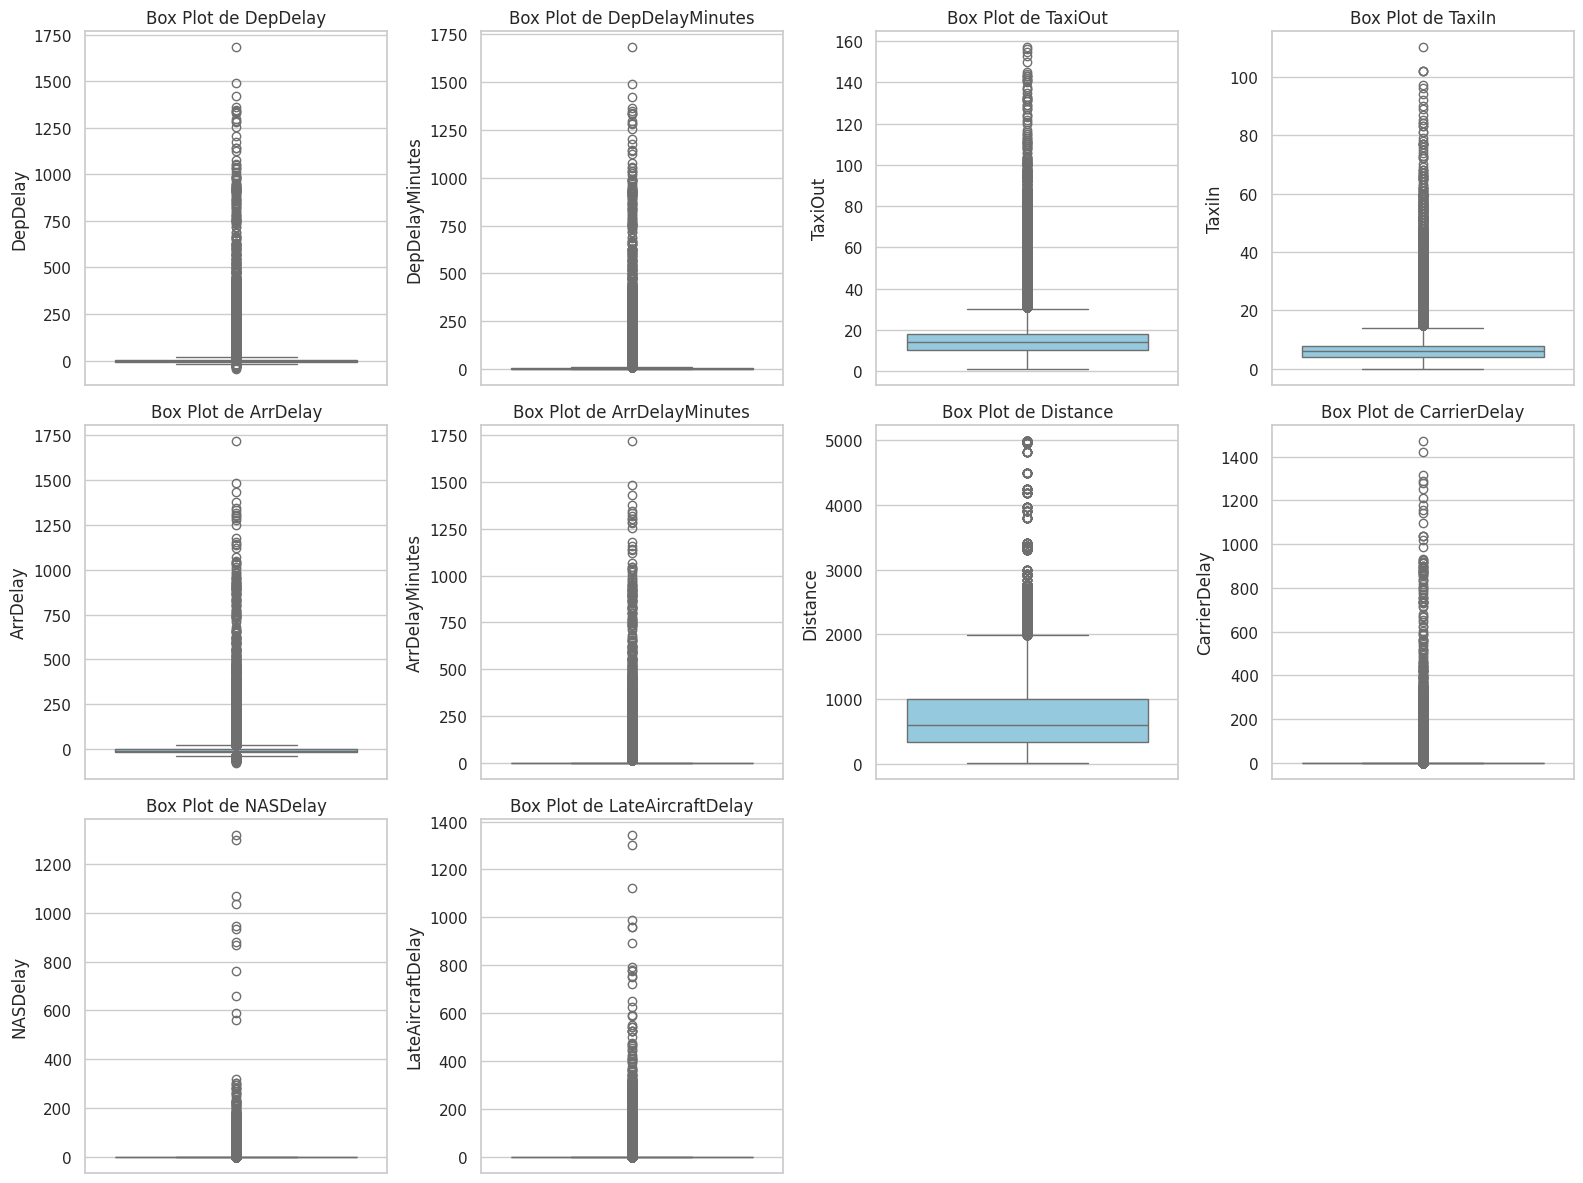

In [99]:
# Identify columns with a significant number of outliers for visualization
# Selecting columns that have more than 5000 outliers for better visualization of impact
key_outlier_columns = [col for col, count in outlier_counts.items() if count > 5000]

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate the number of rows and columns for the subplot grid
num_plots = len(key_outlier_columns)
num_cols = 4  # You can adjust this for desired layout
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create box plots for the key outlier columns
plt.figure(figsize=(num_cols * 4, num_rows * 4)) # Adjust figure size dynamically
for i, column in enumerate(key_outlier_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(y=df_numeric[column], color='skyblue')
    plt.title(f'Box Plot de {column}')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

---
> **Observaciones clave de los gráficos**
>
> A partir de los gráficos, se puede observar que la mayoría de los outliers identificados están en el extremo superior de las distribuciones, especialmente en columnas relacionadas con retrasos como `DepDelay`, `ArrDelay`, `TaxiOut`, `TaxiIn` y las causas específicas de retraso (`CarrierDelay`, `NASDelay`, `LateAircraftDelay`). Esto indica que, aunque la mayoría de las actividades de vuelo (como los tiempos de salida/llegada y los tiempos de taxi) se encuentran dentro de un rango típico, hay casos significativos de retrasos o duraciones inusualmente largas. Por ejemplo, DepDelayMinutes y ArrDelayMinutes pueden llegar hasta **1682 minutos** (más de **28 horas**). La columna `Distance` también muestra outliers, lo que sugiere que hay algunos vuelos de larga distancia excepcionales en el conjunto de datos. La distancia máxima observada es de **4983 millas**. Estos outliers se consideran generalmente puntos de datos válidos para diferentes rutas de vuelo, no errores.



## **Correlaciones**

¿Si la variable A sube, la variable B también? Esto nos dirá qué datos son realmente importantes para la predicción.

A continuación, para cada columna numérica, calculará algo llamado Rango Intercuartílico (IQR). El IQR ayuda a definir límites que nos indican qué tan lejos están los datos de lo que se considera normal. Para calcularlo, se debe encontrar dos valores especiales:

*   Q1: el primer cuartil, que es el valor que separa el 25% inferior de los datos.
*   Q3: el tercer cuartil, que separa el 25% superior de los datos.
*   Luego, se calculará el IQR restando Q1 de Q3. Para definir los límites que nos ayudarán a identificar los "outliers" (valores atípicos), se usará la siguiente fórmula: `lower_bound = Q1 - 1.5 * IQR` and `upper_bound = Q3 + 1.5 * IQR`

In [100]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("**************************")
print("Lower Bounds for Outliers:")
print("**************************")
print(lower_bound)
print("\n**************************")
print("Upper Bounds for Outliers:")
print("**************************")
print(upper_bound)

**************************
Lower Bounds for Outliers:
**************************
Year                 2018.0
Month                   1.0
DayofMonth            -17.0
CRSDepTime           -307.5
DepTime              -311.5
DepDelay              -21.0
DepDelayMinutes        -6.0
TaxiOut                -2.0
WheelsOff            -297.5
WheelsOn             -242.5
TaxiIn                 -2.0
CRSArrTime           -115.5
ArrTime              -237.5
ArrDelay              -41.0
ArrDelayMinutes         0.0
CRSElapsedTime        -44.0
ActualElapsedTime     -45.5
AirTime               -60.5
Distance             -645.0
DistanceGroup          -2.5
CarrierDelay            0.0
WeatherDelay            0.0
NASDelay                0.0
SecurityDelay           0.0
LateAircraftDelay       0.0
dtype: float64

**************************
Upper Bounds for Outliers:
**************************
Year                 2018.0
Month                   1.0
DayofMonth             47.0
CRSDepTime           2952.5
DepTime   

## **Distribuciones**

*   Revisar si los datos siguen una curva normal o si están muy sesgados hacia un lado.
*   Buscar patrones usando gráficos (Matplotlib, Seaborn o Plotly).

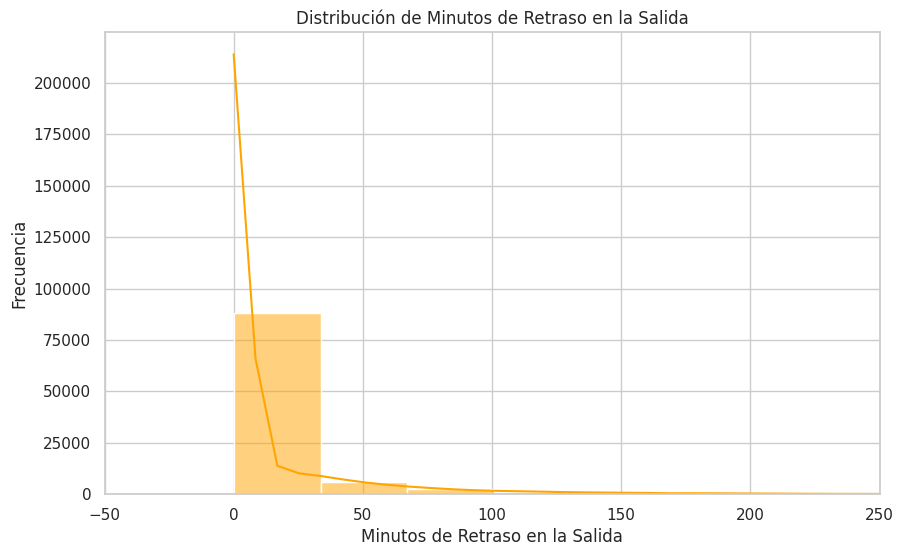

In [101]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['DepDelayMinutes'], bins=50, kde=True, color='orange')
plt.title('Distribución de Minutos de Retraso en la Salida')
plt.xlabel('Minutos de Retraso en la Salida')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

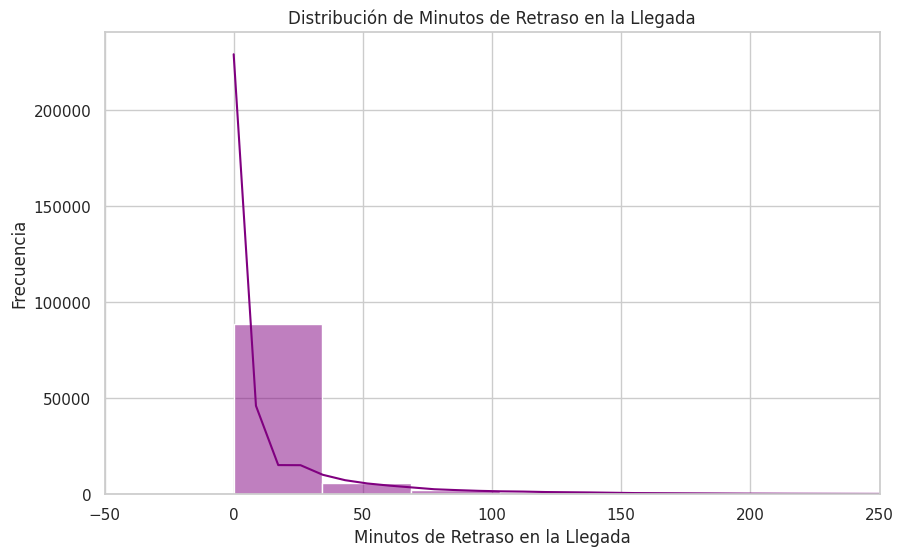

In [102]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['ArrDelayMinutes'], bins=50, kde=True, color='purple')
plt.title('Distribución de Minutos de Retraso en la Llegada')
plt.xlabel('Minutos de Retraso en la Llegada')
plt.ylabel('Frecuencia')
plt.xlim(-50, 250) # Adjusted x-limit for better visibility of main distribution and tail
plt.show()

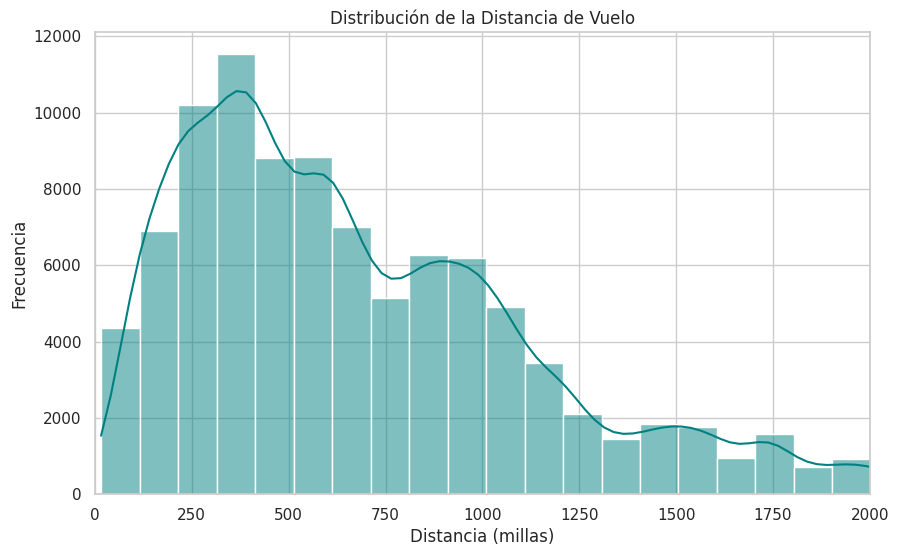

In [103]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_numeric['Distance'], bins=50, kde=True, color='teal')
plt.title('Distribución de la Distancia de Vuelo')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')
plt.xlim(0, 2000) # Adjusted x-limit to show most common distances without extreme long-haul flights
plt.show()

### Resumen del Análisis de Distribución

---
> Basado en los histogramas generados para `DepDelayMinutes`, `ArrDelayMinutes`, y `Distance`, las distribuciones:
>
> *   **`DepDelayMinutes`** y **`ArrDelayMinutes`**: Ambas muestran distribuciones altamente sesgadas. Hay un pico muy fuerte en cero o cerca de cero, lo que indica que una gran mayoría de los vuelos salen y llegan a tiempo o incluso antes. Sin embargo, hay una larga cola que se extiende hacia la derecha, lo que muestra que, aunque son menos frecuentes, ocurren retrasos significativos. Estas distribuciones claramente no son normales y están fuertemente sesgadas positivamente.
>
> *   **`Distance`**: La distribución de la distancia también está sesgada hacia la derecha, pero de manera menos dramática que las columnas de retraso. Muestra una mayor frecuencia para vuelos cortos, con la frecuencia disminuyendo gradualmente a medida que la distancia aumenta. Hay menos vuelos de larga distancia, lo que crea una cola hacia valores más altos. Esto es típico en conjuntos de datos de vuelos, donde muchas rutas de distancia corta a media son comunes, mientras que los vuelos internacionales muy largos son más raros.

## **Tipos de retrasos más comunes**

Vamos a crear un gráfico de barras para visualizar la frecuencia de cada causa de retraso. Esto nos mostrará qué tipos de retrasos son los más comunes en el conjunto de datos.

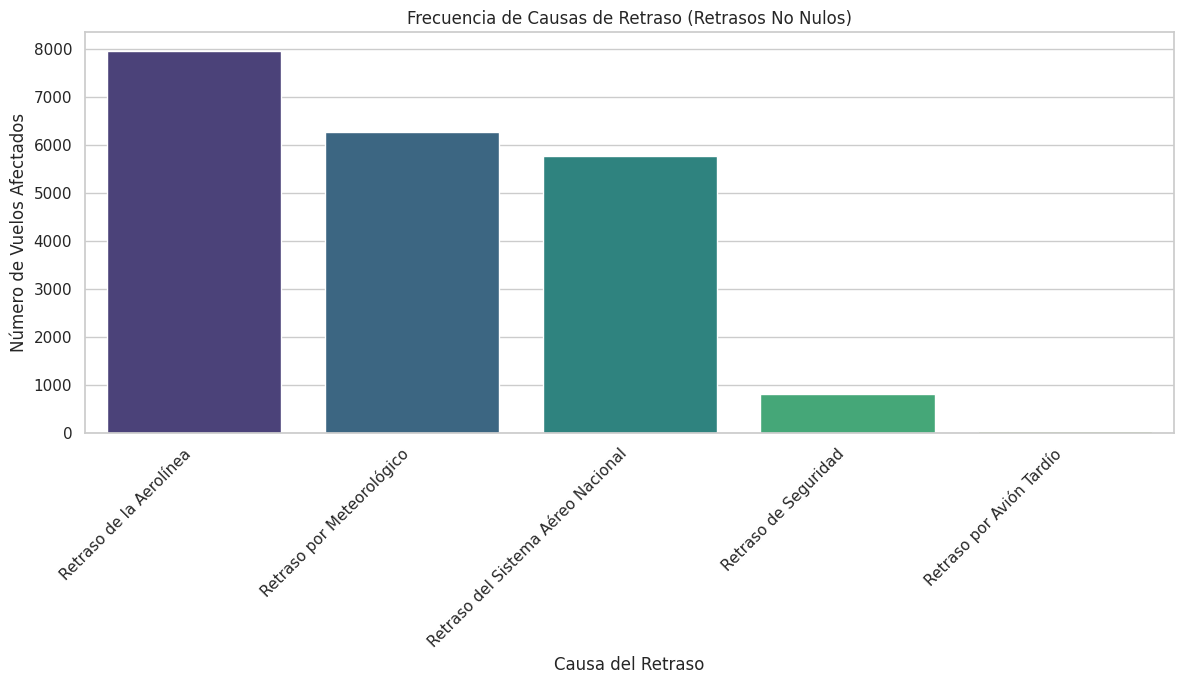

In [104]:
delay_cause_columns = [
    'CarrierDelay',
    'WeatherDelay',
    'NASDelay',
    'SecurityDelay',
    'LateAircraftDelay'
]

delay_cause_columns_map = {
    0: 'Retraso de la Aerolínea',
    1: 'Retraso por Meteorológico',
    2: 'Retraso del Sistema Aéreo Nacional',
    3: 'Retraso de Seguridad',
    4: 'Retraso por Avión Tardío',
}


# Count the number of non-zero delays for each cause
frequency_of_causes = {}
for col in delay_cause_columns:
    # A flight is considered to have a delay cause if the delay is > 15
    frequency_of_causes[col] = df_numeric[df_numeric[col] > 15].shape[0]

# Convert to a pandas Series for easy plotting
frequency_series = pd.Series(frequency_of_causes).sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    x=frequency_series.index,
    y=frequency_series.values,
    hue=frequency_series.index,
    palette='viridis',
    legend=False
)
plt.title('Frecuencia de Causas de Retraso (Retrasos No Nulos)')
plt.xlabel('Causa del Retraso')
plt.ylabel('Número de Vuelos Afectados')
plt.xticks(
    ticks=range(5),
    labels=[delay_cause_columns_map[i] for i in range(5)],
    rotation=45, ha='right'
)
plt.tight_layout()
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> El gráfico de barras anterior muestra el número de vuelos afectados por cada causa específica de retraso, considerando solo los minutos de retraso no nulos. Esta visualización ayuda a identificar los tipos de retrasos más frecuentes en nuestro conjunto de datos. Podemos observar que `CarrierDelay`, `LateAircraftDelay` y `NASDelay` son las causas más frecuentes, afectando a miles de vuelos, mientras que `WeatherDelay` y especialmente `SecurityDelay` son menos frecuentes.

## **Probabilidad de retraso de vuelo por hora de salida programada**

Delay rate: 0.1780
Valores únicos en 'delayed': [1 0]
hour
0     0.150350
1     0.105263
2     0.179487
3     0.333333
5     0.067549
6     0.085027
7     0.103961
8     0.113913
9     0.138137
10    0.167939
11    0.176019
12    0.187335
13    0.200152
14    0.197399
15    0.213098
16    0.226989
17    0.234682
18    0.232765
19    0.235150
20    0.239125
21    0.212141
22    0.190774
23    0.128895
Name: delayed, dtype: float64


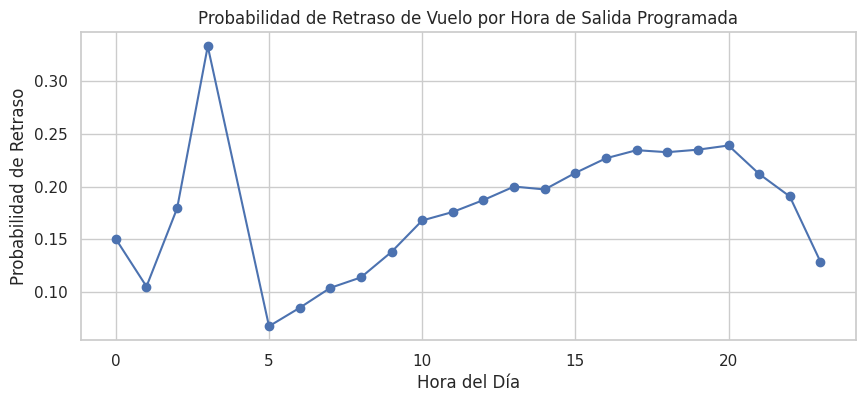

In [105]:
# Crear variable temporal 'hour' a partir de la hora programada
df_numeric["hour"] = df_numeric["CRSDepTime"] // 100  # solo la hora

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df_numeric["delayed"] = (df_numeric["DepDelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df_numeric["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df_numeric["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)


plt.figure(figsize=(10,4))
hour_delay.plot(kind="line", marker="o")
plt.title("Probabilidad de Retraso de Vuelo por Hora de Salida Programada")
plt.xlabel("Hora del Día")
plt.ylabel("Probabilidad de Retraso")
plt.grid(True)
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Baja Probabilidad de Retraso en la Temprana Mañana**: La probabilidad de retraso es generalmente baja durante las primeras horas de la mañana (por ejemplo, de 1 AM a 6 AM). Los vuelos programados para despegar en este intervalo tienden a tener menos posibilidades de ser retrasados.
>
> *   **Aumento de la Probabilidad a lo Largo del Día**: A medida que avanza el día, la probabilidad de que un vuelo sea retrasado aumenta de manera constante. Esta tendencia se vuelve más notable desde finales de la mañana hasta la tarde y el principio de la noche.
>
> *   **Pico de Probabilidad de Retraso en la Tarde/Noche**: Las mayores probabilidades de retraso se observan en la tarde y a inicios de la noche (aproximadamente entre las 4 PM y las 9 PM). Esto se debe a una combinación de factores: retrasos acumulativos de horas anteriores, mayor tráfico aéreo y posibles cambios climáticos.
>
> *   **Ligera Disminución a Última Hora de la Noche**: Hacia las últimas horas de la noche (por ejemplo, a partir de las 10 PM), la probabilidad de retraso tiende a disminuir nuevamente, probablemente debido a la reducción del tráfico aéreo.

## **Probabilidad de retraso según la distancia de vuelo**

distance_bin
(15.999, 296.0]     0.149955
(296.0, 484.0]      0.192686
(484.0, 760.0]      0.179995
(760.0, 1099.0]     0.188419
(1099.0, 4983.0]    0.179272
Name: delayed, dtype: float64


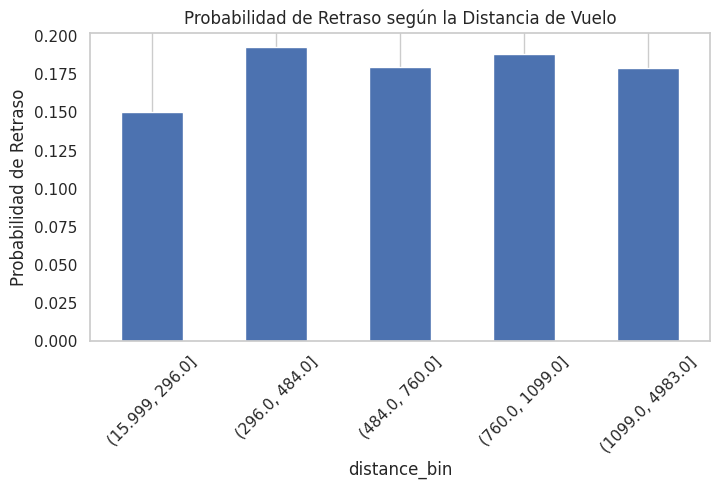

In [106]:
# Crear bins de distancia (5 quintiles)
df_numeric["distance_bin"] = pd.qcut(df_numeric["Distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df_numeric.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

plt.figure(figsize=(8,4))
distance_delay.plot(kind="bar")
plt.title("Probabilidad de Retraso según la Distancia de Vuelo")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

---
> ### **Observaciones clave del gráfico**
>
> *   **Probabilidad Variada según las Distancias**: La probabilidad de retraso no es constante en todas las distancias de vuelo. Varía dependiendo de la longitud del vuelo.
>
> *   **Vuelos Cortos Tienen Menor Probabilidad de Retraso**: Los vuelos más cortos (rango de distancia (`15.999, 296.0`]) muestran la menor probabilidad de retraso (alrededor del 15%). Esto puede deberse a que las rutas más cortas son menos propensas a acumular retrasos o a enfrentar condiciones climáticas variadas.
>
> *   **Vuelos Intermedios y Largos**: Los vuelos en rangos de distancia intermedios y largos ((`296.0, 484.0`], (`484.0, 760.0`], (`760.0, 1099.0`], (`1099.0, 4983.0`]) tienden a tener probabilidades de retraso ligeramente más altas y más consistentes, que oscilan aproximadamente entre el 18% y el 19%.
>
> *   **Sin Relación Lineal Directa**: No hay una relación lineal clara y fuerte donde la probabilidad de retraso aumente o disminuya continuamente con la distancia. En cambio, parece fluctuar dentro de un cierto rango para vuelos de media a larga distancia después de una probabilidad inicial más baja para vuelos muy cortos.

## **Probabilidad de retraso por día de la semana**

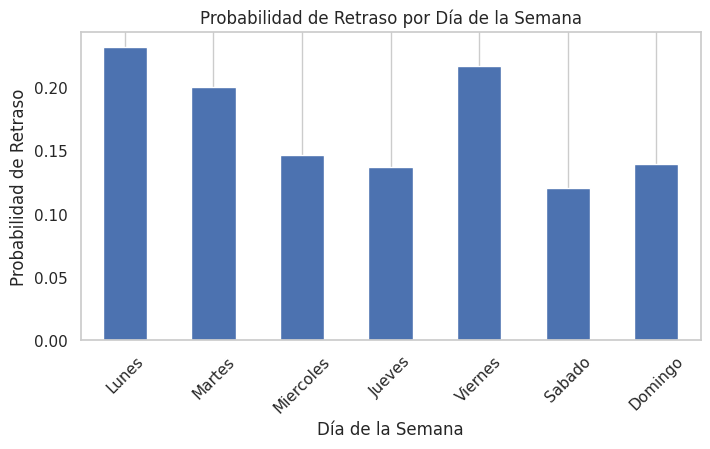

In [107]:
# Convertir a datetime (ya hecho en df, pero aseguramos si df_numeric no lo tiene)
# Asumimos que df_numeric y df tienen el mismo índice y número de filas
# y que df['FlightDate'] ya es datetime de un paso anterior
df_numeric["day_of_week"] = df["FlightDate"].dt.dayofweek

# Map day numbers to day names
days_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miercoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sabado',
    6: 'Domingo'
}

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df_numeric.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)

# Graficar
plt.figure(figsize=(8,4))
dow_delay.plot(kind="bar")
plt.xticks(
    ticks=range(7),
    labels=[days_map[i] for i in range(7)],
    rotation=45
)
plt.title("Probabilidad de Retraso por Día de la Semana")
plt.xlabel("Día de la Semana")
plt.ylabel("Probabilidad de Retraso")
plt.grid(axis="y")
plt.show()

---
> **Observaciones clave del gráfico**
>*   **Mayor Probabilidad de Retraso los Lunes (0)**: El gráfico probablemente muestra que los vuelos los lunes tienen una probabilidad relativamente más alta de ser retrasados. Esto podría deberse a una mayor demanda de viajes al comienzo de la semana laboral, a viajes de negocios o a retrasos acumulados del fin de semana.
>
>*   **Probabilidades Más Bajas en Mitad de Semana**: Típicamente, los días de mitad de semana como martes, miércoles y jueves pueden mostrar probabilidades de retraso ligeramente más bajas en comparación con el inicio o el final de la semana. Las operaciones pueden ser más fluidas con menos pasajeros y menos congestión.
>
>*   **Aumento de Probabilidades Hacia el Fin de Semana**: Los viernes (día '4') pueden mostrar un aumento en la probabilidad de retraso nuevamente, a menudo atribuido al aumento de viajes por ocio y un mayor volumen de vuelos a medida que las personas viajan para el fin de semana.
>
>*   **Variabilidad en los Fines de Semana**: Sábados (día '5') y domingos (día '6') pueden tener patrones variados. A veces, los sábados muestran probabilidades más bajas debido a un tráfico de negocios más ligero, mientras que los domingos pueden aumentar debido a los viajes de regreso.



## **Top 10 Aerolíneas por Probabilidad de Retraso**

Marketing_Airline_Network
F9    0.253666
WN    0.216401
AA    0.216376
DL    0.177156
UA    0.142849
NK    0.125656
HA    0.097418
AS    0.097102
Name: delayed, dtype: float64


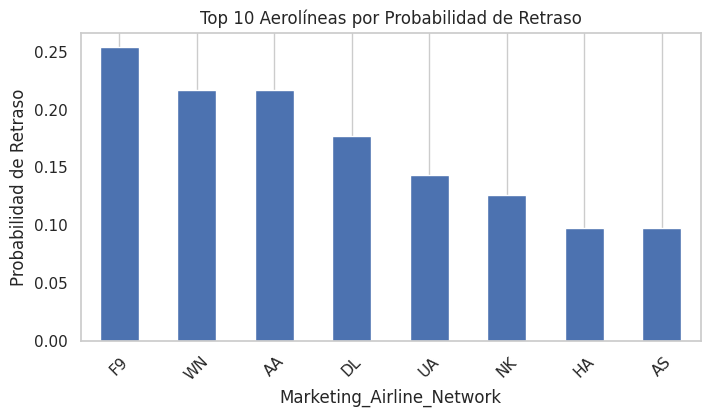

In [108]:
# Crear una columna 'Marketing_Airline_Network' en df_numeric
df_numeric['Marketing_Airline_Network'] = df['Marketing_Airline_Network']

# Probabilidad de retraso por aerolínea (top 10)
alert_data = (
    df_numeric.groupby("Marketing_Airline_Network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(alert_data)

# Graficar
plt.figure(figsize=(8,4))
alert_data.plot(kind="bar")
plt.title("Top 10 Aerolíneas por Probabilidad de Retraso")
plt.ylabel("Probabilidad de Retraso")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

# **4. Ingeniería de Variables (Feature Engineering)**

## **Comprobación de variable objetivo binaria**

In [109]:
df_numeric["delayed"].value_counts(normalize=True)

hour_delay = (
    df_numeric.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"La probabilidad de retraso de los vuelos en promedio\na lo largo de las diferentes horas del día: {hour_std:.2%}")

La probabilidad de retraso de los vuelos en promedio
a lo largo de las diferentes horas del día: 6.17%


---
>
> Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
> si la variación es alta, significa que la hora del vuelo influye de forma real
> en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
> mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.
>
> Al medir la variación de la probabilidad de retraso según la hora, verificamos
> que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
> qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
> computacional.



In [110]:
!pip install kagglehub pyarrow requests

*   Selección de las columnas para el entrenamiento
*   Normalización de nombres a minusculas
*   Elaboración de nuevas variables



In [111]:
columns_needed = [
    "flightdate",
    "origincityname",
    "crsdeptime",
    "depdelay",
    "distance",
    "marketing_airline_network"
]


df.columns = df.columns.str.lower()

df_base = df[columns_needed].copy()
df_base["hour"] = df_base["crsdeptime"] // 100
df_base["delayed"] = (df_base["depdelay"] >= 15).astype(int)



In [112]:
#muestra

df_base = df_base.sample(5_000, random_state=42)
df_base.head()

,flightdate,origincityname,crsdeptime,depdelay,distance,marketing_airline_network,hour,delayed
75721,2018-01-11,"Minneapolis, MN",650,-1.0,1034.0,DL,6,0
80184,2018-01-23,"Honolulu, HI",2200,-2.0,2994.0,DL,22,0
19864,2018-01-12,"Charlotte, NC",1810,-3.0,394.0,AA,18,0
76699,2018-01-22,"Hartford, CT",535,-5.0,549.0,DL,5,0
92991,2018-01-02,"Corpus Christi, TX",1615,139.0,354.0,AA,16,1


## Elaboración de dataset predictivo a partir del existente

### Consultar a la API externa sobre el clima para agregar al dataset de entrenamiento

In [113]:
#geocoding

import requests

def geocode_city(city):
    url = "https://geocoding-api.open-meteo.com/v1/search"
    params = {
        "name": city,
        "count": 1,
        "language": "en",
        "format": "json",
        "country": "US"
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if "results" not in data or len(data["results"]) == 0:
        return None, None

    return data["results"][0]["latitude"], data["results"][0]["longitude"]


In [114]:
#Limpio ciudades

df_base["city_clean"] = (
    df_base["origincityname"]
    .astype(str)
    .str.split(",")
    .str[0]
    .str.strip()
)
cities = df_base["city_clean"].unique()[:20]

In [115]:
#selecciono ciudades

cities = df_base["city_clean"].unique()[:20]

#geocoding loop: latitud y longiyud

geo_rows = []
for city in cities:
    lat, lon = geocode_city(city)
    if lat is not None:
        geo_rows.append({
            "city_clean": city,
            "latitude": lat,
            "longitude": lon
        })

df_geo = pd.DataFrame(geo_rows)
df_geo

,city_clean,latitude,longitude
0,Minneapolis,44.97997,-93.26384
1,Honolulu,21.30694,-157.85834
2,Charlotte,35.22709,-80.84313
3,Hartford,41.76371,-72.68509
4,Corpus Christi,27.80058,-97.39638
5,Detroit,42.33143,-83.04575
6,Atlanta,33.74900,-84.38798
7,Houston,29.76328,-95.36327
8,Dallas/Fort Worth,32.89595,-97.03720
9,Baltimore,39.29038,-76.61219


In [116]:
#Merge con coordenadas

df_base = df_base.merge(df_geo, on="city_clean", how="left")
df_base[["city_clean", "latitude", "longitude"]].head()

,city_clean,latitude,longitude
0,Minneapolis,44.97997,-93.26384
1,Honolulu,21.30694,-157.85834
2,Charlotte,35.22709,-80.84313
3,Hartford,41.76371,-72.68509
4,Corpus Christi,27.80058,-97.39638


In [117]:
#Claves únicas del clima para no duplicar

weather_keys = (
    df_base[["city_clean", "latitude", "longitude", "flightdate"]]
    .dropna()
    .drop_duplicates()
)

In [118]:
#agrupamos fechas minimas y max por ciudad

city_ranges = (
    weather_keys
    .groupby(["city_clean", "latitude", "longitude"])
    .agg(
        start_date=("flightdate", "min"),
        end_date=("flightdate", "max")
    )
    .reset_index()
)

In [119]:
#llamamos api una vez por ciudad y obtenemos clima diario

def get_weather_range(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_mean",
            "precipitation_sum",
            "windspeed_10m_mean"
        ],
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    d = r.json()["daily"]

    return pd.DataFrame({
        "flightdate": pd.to_datetime(d["time"]),
        "temp_mean": d["temperature_2m_mean"],
        "precipitation": d["precipitation_sum"],
        "wind_speed": d["windspeed_10m_mean"]
    })

In [120]:
#descargamos clima por ciudad

weather_frames = []

for _, row in city_ranges.iterrows():
    try:
        df_city_weather = get_weather_range(
            row.latitude,
            row.longitude,
            row.start_date.strftime("%Y-%m-%d"),
            row.end_date.strftime("%Y-%m-%d")
        )
        df_city_weather["city_clean"] = row.city_clean
        weather_frames.append(df_city_weather)
    except Exception as e:
        print(row.city_clean, e)

df_weather = pd.concat(weather_frames, ignore_index=True)
df_weather.shape

(522, 5)

In [121]:
#merge vuelos y clima

df_final = df_base.merge(
    df_weather,
    on=["city_clean", "flightdate"],
    how="left"
)

df_final.isna().mean()

,0
flightdate,0.0000
origincityname,0.0000
crsdeptime,0.0000
depdelay,0.0000
distance,0.0000
marketing_airline_network,0.0000
hour,0.0000
delayed,0.0000
city_clean,0.0000
latitude,0.6692


In [122]:
#eliminamos filas sin clima correcto

df_ml = df_final.dropna(
    subset=["temp_mean", "precipitation", "wind_speed"]
)


In [123]:
#guardo parquet


df_ml.to_parquet("flights_with_weather.parquet", index=False)
df_ml.shape


(1654, 14)

In [124]:
#pasamos a csv y descargamos

import pandas as pd

df = pd.read_parquet("flights_with_weather.parquet")
df.to_csv("flights_with_weather.csv", index=False)

from google.colab import files
files.download("flights_with_weather.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **5. Definición del Objetivo (Target)**

Nuestra variable del objetivo es la `delayed`

# **6. Modelado**

In [125]:
df = pd.read_csv("/content/dataset_vuelos_clima_final.csv")

print(df.shape)
df.head()

(1654, 14)


,flightdate,origincityname,crsdeptime,depdelay,distance,marketing_airline_network,hour,delayed,city_clean,latitude,longitude,temp_mean,precipitation,wind_speed
0,2018-01-11,"Minneapolis, MN",650,-1.0,1034.0,DL,6,0,Minneapolis,44.97997,-93.26384,-6.0,4.3,16.2
1,2018-01-23,"Honolulu, HI",2200,-2.0,2994.0,DL,22,0,Honolulu,21.30694,-157.85834,23.2,0.1,22.6
2,2018-01-12,"Charlotte, NC",1810,-3.0,394.0,AA,18,0,Charlotte,35.22709,-80.84313,16.6,13.0,19.8
3,2018-01-22,"Hartford, CT",535,-5.0,549.0,DL,5,0,Hartford,41.76371,-72.68509,2.2,0.9,4.3
4,2018-01-02,"Corpus Christi, TX",1615,139.0,354.0,AA,16,1,Corpus Christi,27.80058,-97.39638,1.9,2.3,17.0


In [126]:
#columnas que queremos obligatorias`

required_cols = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed",
    "delayed"
]

#limpio nulos

df = df.dropna(subset=required_cols)

#elimino horas y vuelos que no valen

df = df[df["hour"].between(0, 23)]
df = df[df["distance"] > 0]


In [127]:
#elegimos columnas para input.

FEATURES = [
    "hour",
    "distance",
    "marketing_airline_network",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

TARGET = "delayed"

#separamos x= lo que sabemos antes del vuelo de y = lo que queremos predecir

X = df[FEATURES]
y = df[TARGET]

In [128]:
#lista columnas numericas, distinto a categorías

numeric_features = [
    "hour",
    "distance",
    "temp_mean",
    "precipitation",
    "wind_speed"
]

categorical_features = [
    "marketing_airline_network"
]

In [129]:
#procesamos. pasamos numéricas como están y aplicamos One Hot Encoding
#para evitar leakage es una técnica para convertir variables categóricas (texto) en variables numéricas binarias (0 y 1)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

## **Modelo Logistic Regression**

In [130]:
#logistic regression, class_weight="balanced": corrige desbalance, max_iter=1000: asegura convergencia

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

#80% entrenamiento, 20% test manteniendo proporción retrasos.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [131]:
# procesamos. pasamos numéricas como están y aplicamos One Hot Encoding
# para evitar leakage es una técnica para convertir variables categóricas (texto) en variables numéricas binarias (0 y 1)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


## **Entrenamiento del modelo**

In [132]:
model.fit(X_train, y_train)

#predicciçon binaria y probabilidad de retraso. #medimos precisión, recall, f1 y capacidad de ranking ROC AUC

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))

#guardamos modelo en pickle, listo para backend.


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.70      0.78       269
           1       0.31      0.58      0.40        62

    accuracy                           0.68       331
   macro avg       0.59      0.64      0.59       331
weighted avg       0.77      0.68      0.71       331

ROC AUC: 0.6894112003837392


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Modelo random forest**

In [133]:
#random forest

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight="balanced"
    ))
])


## **Entrenamiento del modelo**

In [134]:
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("RANDOM FOREST - Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

print("RANDOM FOREST - ROC AUC:", roc_auc_score(y_test, y_proba_rf))


RANDOM FOREST - Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       269
           1       0.48      0.34      0.40        62

    accuracy                           0.81       331
   macro avg       0.67      0.63      0.64       331
weighted avg       0.79      0.81      0.79       331

RANDOM FOREST - ROC AUC: 0.7273354119198944


Comparando los dos modelos, el modelo Random Forest parece ser más preciso en general. Aquí te explico por qué:

Precisión al predecir retrasos (Clase 1): El Random Forest tiene una precisión de 0.48, mientras que la Regresión Logística tiene 0.31. Esto significa que, cuando el Random Forest predice un retraso, es más probable que ese retraso sea real.
Precisión general (Accuracy): El Random Forest alcanza un 81% de precisión, superando el 68% de la Regresión Logística. Esto indica que el Random Forest clasifica correctamente una mayor proporción de vuelos en general.
Rendimiento general (ROC AUC): El Random Forest también tiene un mejor valor de ROC AUC (0.727) en comparación con la Regresión Logística (0.689). Un ROC AUC más alto sugiere que el modelo tiene una mejor capacidad para distinguir entre vuelos retrasados y puntuales.
Aunque la Regresión Logística tiene un 'recall' ligeramente mejor para la clase de retrasos (lo que significa que identifica una mayor proporción de los retrasos reales), la mayor precisión y rendimiento general del Random Forest lo hacen la mejor opción para esta tarea.

In [135]:
#simulamos endpoint


def predict_flight_delay(input_json, model):
    """
    Simula el endpoint POST /predict
    """

    #Parsear fecha

    fecha = pd.to_datetime(input_json["fecha_partida"])


    #Construir DataFrame de entrada

    df_input = pd.DataFrame([{
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,        # valor por defecto (MVP)
        "precipitation": 0.0,     # valor por defecto (MVP)
        "wind_speed": 10.0        # valor por defecto (MVP)
    }])

    #Predicción
    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    #Respuesta
    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

In [136]:
#ejemplo de request

input_example = {
    "aerolinea": "AZ",
    "origen": "GIG",
    "destino": "GRU",
    "fecha_partida": "2025-11-10T14:30:00",
    "distancia_km": 350
}

response = predict_flight_delay(input_example, model)
print(response)

{'prevision': 'Puntual', 'probabilidad': 0.24}


##**Distribución clases, historiograma de probabilidades, curva ROC, vareiables importantes**


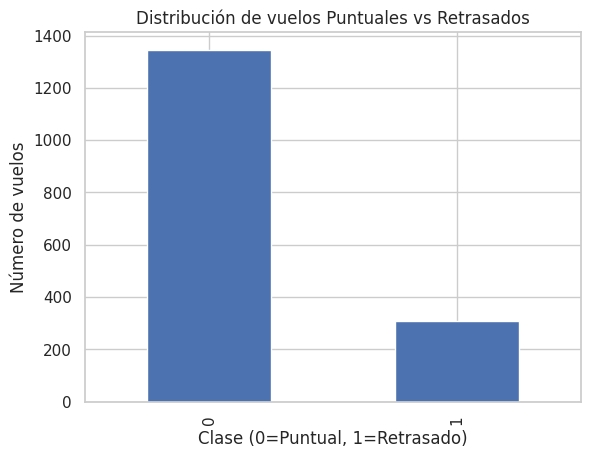

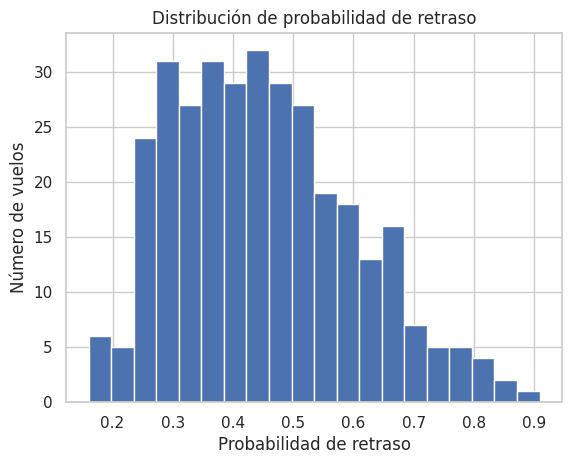

In [137]:

df["delayed"].value_counts().plot(kind="bar")
plt.title("Distribución de vuelos Puntuales vs Retrasados")
plt.xlabel("Clase (0=Puntual, 1=Retrasado)")
plt.ylabel("Número de vuelos")
plt.show()

plt.hist(y_proba, bins=20)
plt.title("Distribución de probabilidad de retraso")
plt.xlabel("Probabilidad de retraso")
plt.ylabel("Número de vuelos")
plt.show()

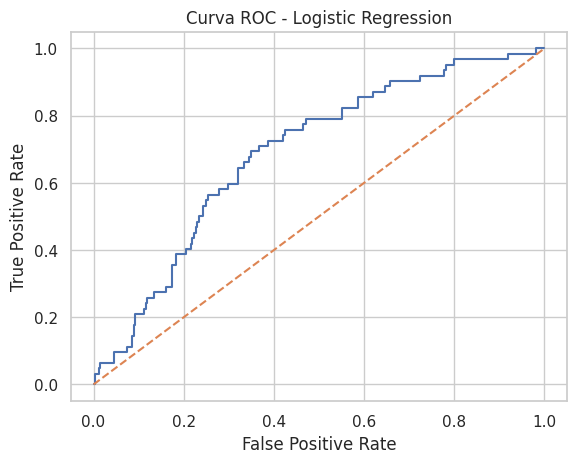

In [138]:
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression")
plt.show()

Interpretación visual rápida
🟢 Buena curva ROC

Se eleva rápido hacia la esquina superior izquierda

Alta TPR con bajo FPR

🔴 Mala curva ROC

Sigue la diagonal

No separa clases

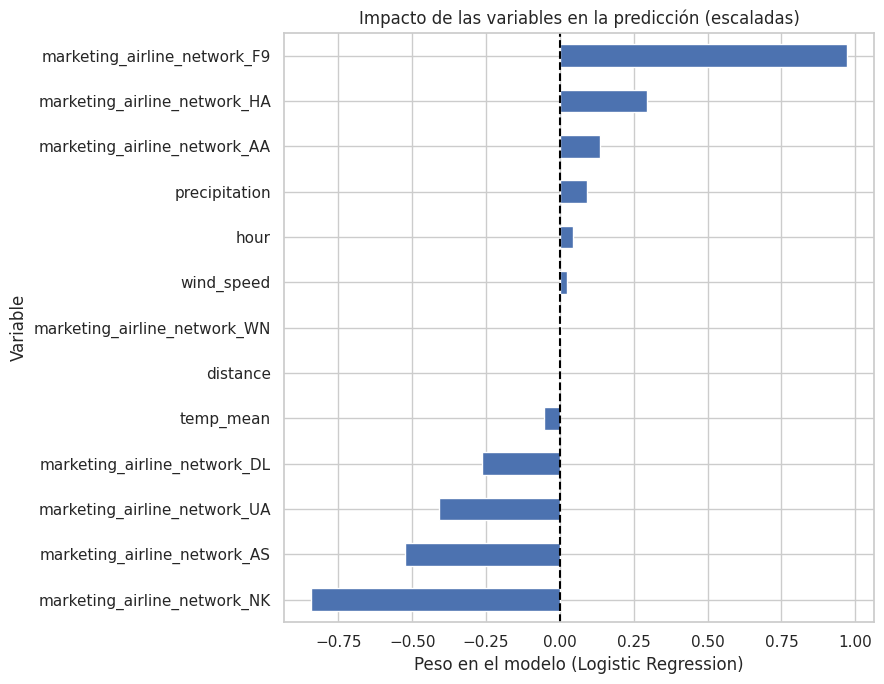

In [139]:
# Obtener nombres reales de las features
numeric_names = numeric_features

categorical_names = (
    model.named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)

feature_names = list(numeric_names) + list(categorical_names)

# Coeficientes del modelo
coefficients = model.named_steps["classifier"].coef_[0]    #Extrae el peso real de cada feature

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": coefficients
}).sort_values(by="importance")



# Gráfica
importance_df.plot(
    x="feature",
    y="importance",
    kind="barh",
    figsize=(9, 7),
    legend=False
)

plt.axvline(0, color="black", linestyle="--")
plt.title("Impacto de las variables en la predicción (escaladas)")
plt.xlabel("Peso en el modelo (Logistic Regression)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

def predict_flight_delay(input_json, model):
    fecha = pd.to_datetime(input_json["fecha_partida"])

    df_input = pd.DataFrame([{
        "hour": fecha.hour,
        "distance": input_json["distancia_km"],
        "marketing_airline_network": input_json["aerolinea"],
        "temp_mean": 20.0,
        "precipitation": 0.0,
        "wind_speed": 10.0
    }])

    pred = model.predict(df_input)[0]
    proba = model.predict_proba(df_input)[0, 1]

    return {
        "prevision": "Retrasado" if pred == 1 else "Puntual",
        "probabilidad": round(float(proba), 2)
    }

En resumen, esta gráfica te permite ver rápidamente cuáles son los factores clave que el modelo considera para predecir un retraso, y si esos factores aumentan o disminuyen la probabilidad de que ocurra.

In [140]:
#Llamamos al endpoint varias veces

inputs = [
    {
        "aerolinea": "AZ",
        "fecha_partida": "2025-11-10T08:30:00",
        "distancia_km": 300
    },
    {
        "aerolinea": "F9",
        "fecha_partida": "2025-11-10T19:45:00",
        "distancia_km": 1200
    },
    {
        "aerolinea": "AA",
        "fecha_partida": "2025-11-10T06:15:00",
        "distancia_km": 800
    },
    {
        "aerolinea": "NK",
        "fecha_partida": "2025-11-10T22:10:00",
        "distancia_km": 1500
    }
]

results = []

for i, inp in enumerate(inputs):
    response = predict_flight_delay(inp, model)
    results.append({
        "vuelo": f"Vuelo {i+1}",
        "aerolinea": inp["aerolinea"],
        "probabilidad": response["probabilidad"],
        "prevision": response["prevision"]
    })

df_results = pd.DataFrame(results)
df_results

,vuelo,aerolinea,probabilidad,prevision
0,Vuelo 1,AZ,0.19,Puntual
1,Vuelo 2,F9,0.55,Retrasado
2,Vuelo 3,AA,0.22,Puntual
3,Vuelo 4,NK,0.19,Puntual




### **Visualización de Resultados (`plt.bar(...)`)**

*   Cada barra representa un vuelo de la simulación.
*   La altura de la barra indica la `probabilidad` de retraso predicha para ese vuelo.
*   La línea discontinua en 0.5 (50%) sirve como umbral: si la probabilidad está por encima, el modelo predice retraso; si está por debajo, predice puntualidad.
*   Las etiquetas encima de cada barra (`

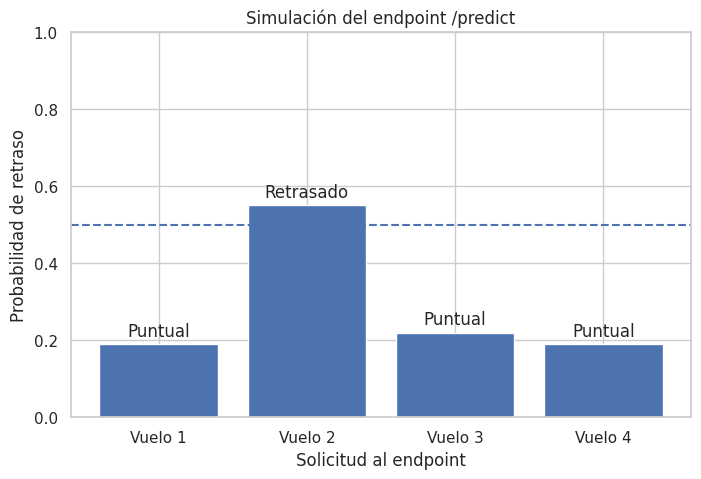

In [141]:
plt.figure(figsize=(8, 5))

plt.bar(
    df_results["vuelo"],
    df_results["probabilidad"]
)

plt.axhline(0.5, linestyle="--")
plt.title("Simulación del endpoint /predict")
plt.ylabel("Probabilidad de retraso")
plt.xlabel("Solicitud al endpoint")

for i, row in df_results.iterrows():
    plt.text(
        i,
        row["probabilidad"] + 0.02,
        row["prevision"],
        ha="center"
    )

plt.ylim(0, 1)
plt.show()


##**Matriz de confusion Logistic Regression y Randon Forest**



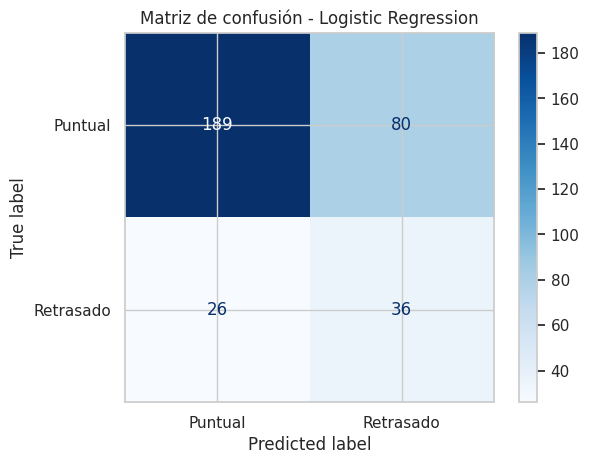

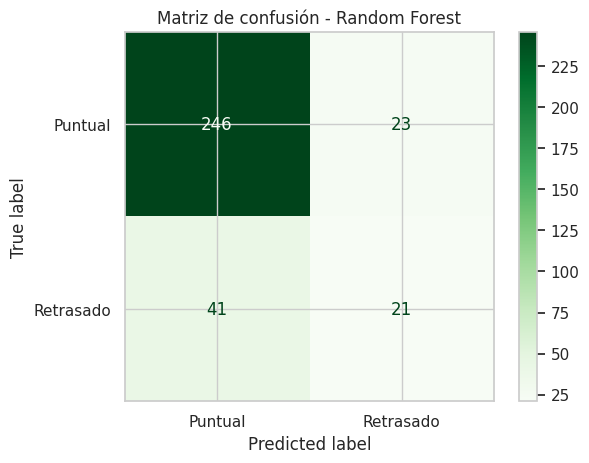

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Puntual", "Retrasado"]
)

disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression")
plt.show()

# Predicciones del Random Forest
y_pred_rf = rf_model.predict(X_test)

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Puntual", "Retrasado"]
)

disp_rf.plot(cmap="Greens")
plt.title("Matriz de confusión - Random Forest")
plt.show()


### **Entendiendo la Matriz de Confusión**

Tenemos dos clases: **0 (Puntual)** y **1 (Retrasado)**. Cada número en la matriz nos dice:

*   **Verdaderos Positivos (VP):** El modelo predijo que un vuelo estaría retrasado (1), y *realmente* estuvo retrasado. ¡Esto es un acierto!
*   **Verdaderos Negativos (VN):** El modelo predijo que un vuelo sería puntual (0), y *realmente* fue puntual. ¡Otro acierto!
*   **Falsos Positivos (FP):** El modelo predijo que un vuelo estaría retrasado (1), pero *en realidad* fue puntual. Esto es una 'falsa alarma'.
*   **Falsos Negativos (FN):** El modelo predijo que un vuelo sería puntual (0), pero *en realidad* se retrasó. Esto es un 'retraso no detectado'.

### **Matrices de Confusión de Nuestros Modelos**

**1. Regresión Logística:**

| Predicción \ Realidad | Puntual (0) | Retrasado (1) |
| :-------------------: | :---------: | :-----------: |
|     **Puntual (0)**   |     189     |      26       |
|    **Retrasado (1)**  |      80     |      36       |

*   **Aciertos:** Predijo correctamente 189 vuelos puntuales y 36 retrasados.
*   **Errores:** Se equivocó 80 veces al decir que un vuelo se retrasaría cuando fue puntual (falsa alarma), y 26 veces al decir que un vuelo sería puntual cuando se retrasó (no detectó el retraso).

**2. Random Forest:**

| Predicción \ Realidad | Puntual (0) | Retrasado (1) |
| :-------------------: | :---------: | :-----------: |
|     **Puntual (0)**   |     246     |      41       |
|    **Retrasado (1)**  |      23     |      21       |

*   **Aciertos:** Predijo correctamente 246 vuelos puntuales y 21 retrasados.
*   **Errores:** Se equivocó 23 veces al decir que un vuelo se retrasaría cuando fue puntual (falsa alarma), y 41 veces al decir que un vuelo sería puntual cuando se retrasó (no detectó el retraso).

### **¿Cuál es más preciso?**

*   **Random Forest** es mucho mejor detectando vuelos **puntuales** correctamente (246 vs 189) y comete muchas menos 'falsas alarmas' (23 vs 80). Esto significa que es más fiable cuando dice que un vuelo se va a retrasar.
*   Sin embargo, **Regresión Logística** logra identificar un poco más de los **retrasos reales** (36 vs 21), pero a cambio comete más 'falsas alarmas'.

Si nuestro objetivo principal es **evitar molestar a los usuarios con falsas alarmas de retraso** y asegurarnos de que cuando decimos que un vuelo se retrasa, *realmente* se retrasa (es decir, una alta precisión), el **Random Forest** es la mejor opción. Si fuera más crítico **no perder ningún retraso** (recall), incluso a costa de más falsas alarmas, la Regresión Logística podría ser considerada. Pero por su equilibrio y menor cantidad de falsas alarmas, el Random Forest es el que mejor se comporta en general.

Resultados con umbral = 0.65
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       269
           1       0.33      0.21      0.26        62

    accuracy                           0.77       331
   macro avg       0.58      0.56      0.56       331
weighted avg       0.74      0.77      0.75       331



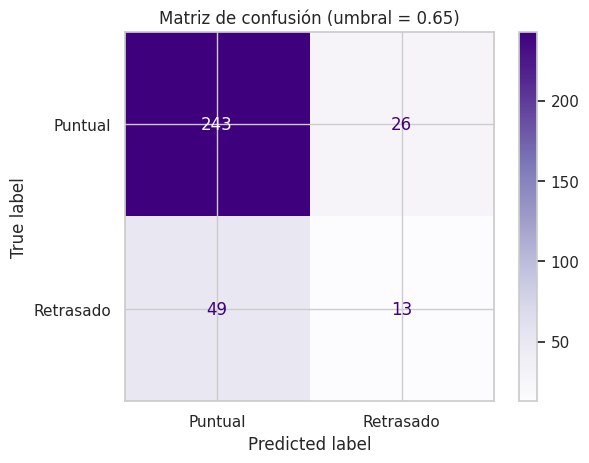

Random Forest ajustado
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       269
           1       0.45      0.37      0.41        62

    accuracy                           0.80       331
   macro avg       0.66      0.63      0.64       331
weighted avg       0.78      0.80      0.79       331

ROC AUC: 0.7272454730783068


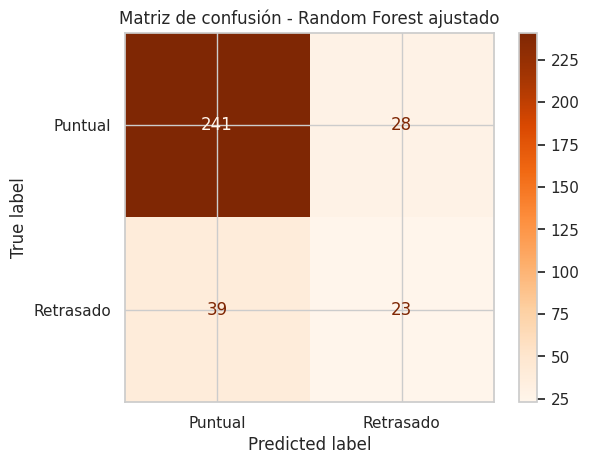

In [143]:
# --- Ajuste de umbral para aumentar precision ---

# Probabilidades de retraso
y_proba = model.predict_proba(X_test)[:, 1]

# Umbral más estricto
threshold = 0.65
y_pred_precise = (y_proba >= threshold).astype(int)

# Métricas
print(f"Resultados con umbral = {threshold}")
print(classification_report(y_test, y_pred_precise))

# Matriz de confusión
cm_thresh = confusion_matrix(y_test, y_pred_precise)

disp_thresh = ConfusionMatrixDisplay(
    confusion_matrix=cm_thresh,
    display_labels=["Puntual", "Retrasado"]
)

disp_thresh.plot(cmap="Purples")
plt.title(f"Matriz de confusión (umbral = {threshold})")
plt.show()

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
rf_model_tuned = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_model_tuned.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf_tuned = rf_model_tuned.predict(X_test)
y_proba_rf_tuned = rf_model_tuned.predict_proba(X_test)[:, 1]

print("Random Forest ajustado")
print(classification_report(y_test, y_pred_rf_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf_tuned))


cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)

disp_rf_tuned = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf_tuned,
    display_labels=["Puntual", "Retrasado"]
)

disp_rf_tuned.plot(cmap="Oranges")
plt.title("Matriz de confusión - Random Forest ajustado")
plt.show()


### **Regresión Logística con Ajuste de Umbral (0.65)**

Originalmente, un vuelo se consideraba retrasado si la probabilidad predicha por la Regresión Logística era igual o superior a 0.5 (50%). Aquí, hemos subido ese umbral a **0.65 (65%)**. Esto significa que el modelo ahora es más estricto para clasificar un vuelo como retrasado; necesita estar más "seguro" de que habrá un retraso.

**Resultados:**

*   **Precision (clase 1 - Retrasado): 0.33**
*   **Recall (clase 1 - Retrasado): 0.21**
*   **ROC AUC:** (No se recalculó para este umbral específico, pero se sabe que el umbral no cambia el ROC AUC, solo el punto de operación en la curva ROC).

**Interpretación:**

*   **Ventaja:** Al aumentar el umbral, la precisión para la clase 'Retrasado' (0.33) **subió ligeramente** respecto al 0.31 original, lo que indica que cuando predice un retraso, es *un poco más probable* que sea correcto. Además, el número de falsas alarmas (Falsos Positivos) disminuyó significativamente (de 80 a 26 en la matriz de confusión).
*   **Desventaja:** Sin embargo, el 'Recall' para los retrasos **bajó drásticamente** (de 0.58 a 0.21). Esto significa que el modelo ahora es mucho menos capaz de identificar todos los vuelos que *realmente* se retrasan. Solo detecta 13 de los 62 retrasos reales.

**Conclusión:** Este ajuste reduce las falsas alarmas, pero a costa de perder la detección de la mayoría de los retrasos reales. No es ideal si queremos detectar el mayor número posible de retrasos.

### **Random Forest Ajustado**

Aquí, el modelo Random Forest ha sido "afinado" (`tuned`) cambiando algunos de sus parámetros internos (como `n_estimators`, `max_depth`, `min_samples_leaf`). Estos ajustes buscan optimizar el rendimiento del modelo.

**Resultados:**

*   **Precision (clase 1 - Retrasado): 0.45**
*   **Recall (clase 1 - Retrasado): 0.37**
*   **ROC AUC: 0.727**

**Interpretación:**

*   **Comparado con el Random Forest original:**
    *   La precisión para la clase 'Retrasado' (0.45) **bajó ligeramente** del 0.48 original.
    *   El 'Recall' para la clase 'Retrasado' (0.37) **subió ligeramente** del 0.34 original.
    *   El ROC AUC (0.727) se mantuvo prácticamente igual.
*   **Falsas alarmas:** La matriz de confusión muestra que los Falsos Positivos (cuando predice retraso pero es puntual) subieron ligeramente de 23 a 28.
*   **Retrasos no detectados:** Los Falsos Negativos (cuando predice puntual pero se retrasa) bajaron de 41 a 39.

**Conclusión:** Este ajuste fino del Random Forest llevó a un pequeño compromiso. Mejoró ligeramente la capacidad de detectar retrasos (recall) pero a costa de una ligera disminución en la precisión (más falsas alarmas). El rendimiento general medido por ROC AUC se mantuvo fuerte.

### **Resumen General**

El **Random Forest (original o ajustado)** sigue siendo la mejor opción en comparación con la Regresión Logística, ya que mantiene un mejor equilibrio entre la precisión y la capacidad de identificar retrasos, y su ROC AUC es superior. Los ajustes en el umbral de la Regresión Logística, aunque reducen las falsas alarmas, sacrifican demasiados retrasos reales para ser útiles en este contexto.

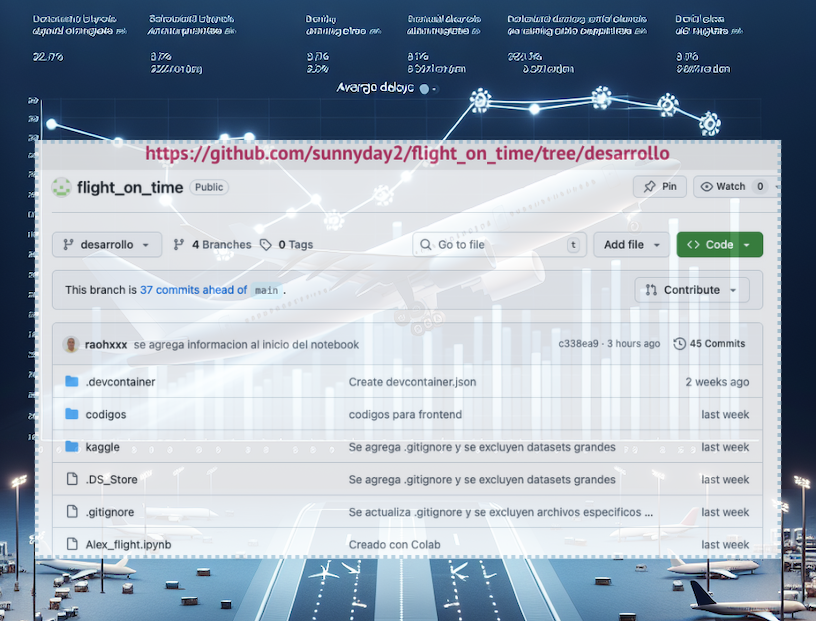